In [2]:
import numpy as np
import torch

import topotorch.src.utils as _utils
import topotorch.src.geometry as _geom
import topotorch.src.mesher as _mesher
import topotorch.src.material as _mat
import topotorch.src.bc as _bc

import topotorch.src.fe_struct as _fea
import topotorch.src.viz as _viz

_Disp = _fea.DisplacementField

## Mesh

<Axes: xlabel='X', ylabel='Y'>

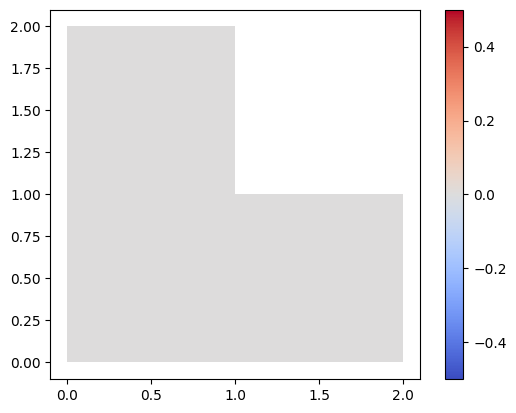

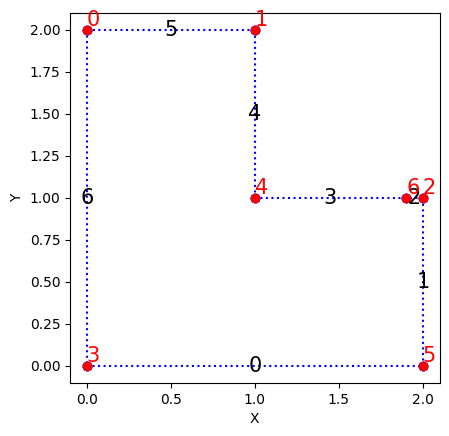

In [3]:
geom = _geom.BrepGeometry("topotorch/mesh/Lbeam.json")

mesh = _mesher.grid_mesh_brep(
  brep=geom,
  nelx_desired=80,
  nely_desired=80,
  dofs_per_node=2,
  gauss_order=3,
)

density = np.zeros(mesh.num_elems)
_viz.plot_grid_mesh(mesh, density)
_viz.plot_brep(geom)

## Material

In [4]:
material_params = _mat.StructuralMaterial(
  youngs_modulus=1.0,
  poissons_ratio=0.30,
)

In [5]:
youngs_mod = torch.ones((mesh.num_elems,))

In [6]:
lame_lams, lame_mus = _mat.get_lame_parameters_from_youngs_modulus_and_poissons_ratio(
  youngs_mod, material_params.poissons_ratio
)

## BC

<Axes: title={'center': 'Boundary Conditions'}>

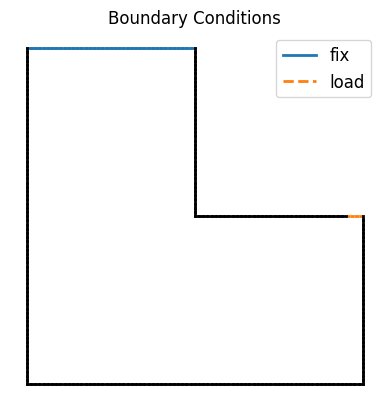

In [ ]:
hang_faces = _bc.identify_faces(mesh, edges=[geom.edges[2]])
n = len(hang_faces)
hang_face_val = [(_Disp.V, -5.0e-4 * np.ones(n))]


top_faces = _bc.identify_faces(mesh, edges=[geom.edges[5]])
n = len(top_faces)
xv = (_Disp.U, np.zeros(n))
yv = (_Disp.V, np.zeros(n))

top_face_val = [xv, yv]

fixed_bc = _bc.DirichletBC(elem_faces=top_faces, values=top_face_val, name="fix")
load_bc = _bc.NeumannBC(elem_faces=hang_faces, values=hang_face_val, name="load")

bc_list = [fixed_bc, load_bc]
bc = _bc.process_boundary_conditions(bc_list, mesh)

_viz.plot_bc(bc_list, mesh)

In [14]:
force = torch.zeros((mesh.num_dofs,), dtype=torch.double)
force = force.index_add(
  0,
  _utils.to_torch(mesh.elem_dof_mat.flatten(), dtype=torch.long),
  bc["elem_forces"].flatten().double(),
)
bc["force"] = force

## FEA

In [15]:
fea = _fea.FEA(
  mesh=mesh,
  bc=bc,
  mat=material_params,
)

In [16]:
comp, u = fea.loss_function(lame_lams, lame_mus)

In [17]:
u_mag = torch.sqrt(u[0::2] ** 2 + u[1::2] ** 2).cpu().numpy()
delta = torch.stack([u[0::2], u[1::2]], dim=1).cpu().numpy()
def_mesh = _mesher.deform_mesh(mesh, delta)

<Axes: >

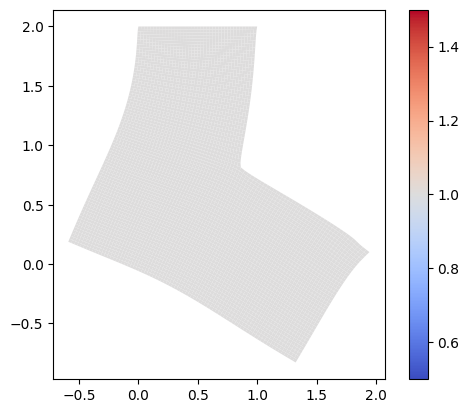

In [18]:
_viz.plot_grid_mesh(def_mesh, youngs_mod.cpu().numpy())